In [0]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from collections import Counter
from tqdm import tqdm_notebook
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
df_prec = pd.read_csv('/content/gdrive/My Drive/customs/prec_with_corrections.csv', sep = ',')
#df_prec = pd.read_csv('/content/gdrive/My Drive/customs/precedents.csv', sep = ';')
df_prec.columns

Index(['ten_code', 'six_code', 'prec_description', 'corrections'], dtype='object')

### Data preprocessing, lengths


In [4]:
df_prec = df_prec[df_prec['prec_description'].map(len) > 1].reset_index(drop=True)
#df_prec = df_prec[df_prec['corrections'].map(len) > 1].reset_index(drop=True)
df_prec = df_prec.drop_duplicates().reset_index(drop=True)
len(df_prec)

314298

In [0]:
len(df_prec.drop_duplicates()) #length without duplicates

314298

In [5]:
(len(df_prec.corrections.unique())/len(df_prec.drop_duplicates()))*100    #percent of unique descreptions with one label

87.15009322362853

In [6]:
len(df_prec)

314298

mean description length:  5.807860692718376+-3.963803504333191


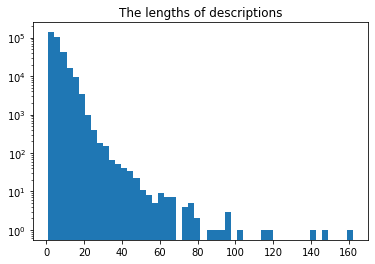

In [7]:
#descrp_lens = [len(df_prec['prec_description'][i].split()) for i in range(len(df_prec))]
descrp_lens = [len(df_prec['corrections'][i].split()) for i in range(len(df_prec))]
df_prec['descrp_lens'] = descrp_lens
print('mean description length: ', str(np.mean(np.array(descrp_lens)))+ '+-' + str(np.std(np.array(descrp_lens)))) 
plt.hist(descrp_lens, bins=50)
plt.title('The lengths of descriptions')
plt.yscale('log')

In [8]:
del descrp_lens
df_prec.head()

,ten_code,six_code,prec_description,corrections,descrp_lens
0,7308909809,730890,части магистрального ленточного конвейера круп...,части магистрального ленточного конвейера круп...,16
1,8431498009,843149,компоненты гусеничного крана бывший в употребл...,компоненты гусеничного крана бывший употреблен...,15
2,3919900000,391990,скотч,скотч,1
3,7326909409,732690,балка,балка,1
4,7326909409,732690,уголки,уголки,1


In [9]:
df_prec = df_prec[df_prec.descrp_lens < 100].reset_index(drop=True)
len(df_prec)

314292

Text(0.5, 1.0, 'The lenghts of descriptions')

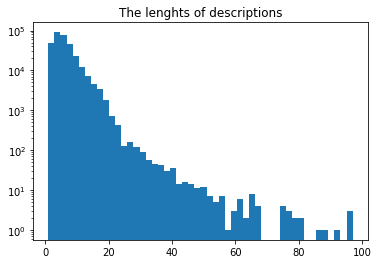

In [10]:
plt.hist(df_prec['descrp_lens'], bins=50)
plt.yscale('log')
plt.title("The lenghts of descriptions")

### Data generation (here we choose the number of classes)

In [11]:
class_counts = Counter(df_prec['six_code'])
classes = []
classes += [k for k, v in class_counts.items() if v >= 300]
len(classes)

194

In [12]:
rare_classes = [k for k, v in class_counts.items() if v < 300]
with open('/content/gdrive/My Drive/customs/rare_classes.txt', 'w') as of:
  of.write('These classes were occured less than 10 times:\n')
  for code in rare_classes:
    of.write(str(code) + '\n')
  
print('These classes occured less than 10 times: ', rare_classes)

These classes occured less than 10 times:  [481420, 841899, 630710, 210390, 200570, 70200, 252321, 520612, 380892, 70951, 70511, 70993, 70960, 292910, 80810, 320619, 550320, 390190, 390330, 252210, 81090, 691490, 870891, 630532, 30354, 441400, 600622, 390230, 731029, 381590, 630221, 390110, 70690, 732620, 854420, 340213, 640690, 640620, 350691, 732290, 940389, 481910, 70110, 70999, 392111, 831110, 71080, 290545, 291814, 151790, 71090, 71022, 721632, 80719, 680100, 730419, 200410, 390690, 480256, 350699, 391620, 580410, 320810, 71030, 950590, 481320, 250100, 292241, 390950, 870810, 281410, 850520, 320611, 441899, 252020, 80521, 70410, 391721, 392043, 630622, 70700, 80550, 350400, 721790, 481159, 870892, 392390, 392530, 392099, 390410, 170490, 611790, 481092, 120242, 481099, 481190, 630533, 392049, 901910, 820760, 71320, 392020, 854460, 950691, 820730, 700600, 940690, 630900, 20714, 741110, 621133, 961900, 392630, 81050, 80430, 392113, 700991, 392520, 730900, 482030, 80830, 80610, 60319,

In [13]:
df_short = pd.DataFrame()
df_short = df_prec.loc[df_prec['six_code'].isin(classes)]
df_short.head()

,ten_code,six_code,prec_description,corrections,descrp_lens
0,7308909809,730890,части магистрального ленточного конвейера круп...,части магистрального ленточного конвейера круп...,16
1,8431498009,843149,компоненты гусеничного крана бывший в употребл...,компоненты гусеничного крана бывший употреблен...,15
2,3919900000,391990,скотч,скотч,1
3,7326909409,732690,балка,балка,1
4,7326909409,732690,уголки,уголки,1


In [0]:
import pickle
d = {ni: indi for indi, ni in enumerate(set(df_short['six_code']))}
numbers = [d[ni] for ni in df_short['six_code']]

num_to_code = {value: key for key, value in d.items()}

with open('/content/gdrive/My Drive/customs/num_to_code.pickle', 'wb') as f:
    pickle.dump(num_to_code, f)


df_short['classes_six'] = numbers
df_short.head(20)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,ten_code,six_code,prec_description,corrections,descrp_lens,classes_six
0,7308909809,730890,части магистрального ленточного конвейера круп...,части магистрального ленточного конвейера круп...,16,87
1,8431498009,843149,компоненты гусеничного крана бывший в употребл...,компоненты гусеничного крана бывший употреблен...,15,151
2,3919900000,391990,скотч,скотч,1,113
3,7326909409,732690,балка,балка,1,5
4,7326909409,732690,уголки,уголки,1,5
5,7326909409,732690,плита,плита,1,5
6,3926909709,392690,кабельные стяжки,кабельные стяжки,2,189
8,3917390008,391739,спиральный шланг м,спиральный шланг,2,16
9,7326909409,732690,обжимной хомут,обжимной хомут,2,5
10,8544499509,854449,кабель вольт,кабель вольт,2,174


In [0]:
len(d)

194

### Text preprocessing for classification

In [0]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [0]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

##### Train / val


In [0]:
#without cross validation - only one train and test
from sklearn.model_selection import train_test_split


#data_train, data_test = train_test_split(df_short, test_size=0.1, shuffle = True, random_state=seed)
data_train, data_val = train_test_split(df_short, test_size=0.2, shuffle = True, random_state=seed, stratify=list(df_short['six_code']))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  210906
Validation size =  52727


In [0]:
import gensim

# Load pre-trained skipgram model.
model_emb = gensim.models.KeyedVectors.load_word2vec_format('/content/gdrive/My Drive/customs/all.norm-sz100-w10-cb0-it1-min100.w2v', binary=True, unicode_errors='ignore')
#model_emb = gensim.models.KeyedVectors.load_word2vec_format('/content/gdrive/My Drive/customs/wiki.ru.vec', binary=False, unicode_errors='ignore')
#model_emb2 = gensim.models.KeyedVectors.load_word2vec_format('/content/gdrive/My Drive/customs/model.bin', binary=True, unicode_errors='ignore')
#model_emb = gensim.models.KeyedVectors.load_word2vec_format('/content/gdrive/My Drive/customs/ft_native_300_ru_wiki_lenta_lower_case.vec', binary=True, unicode_errors='ignore')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
tokenized_texts = [text.split() for text in list(data_train['corrections'])]

In [0]:
# train word2vec on data
model = gensim.models.Word2Vec(tokenized_texts, size=100, min_count=2, window=3, sg=0, seed=seed)
model_emb2 = dict(zip(model.wv.index2word, model.wv.syn0))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


In [0]:
def data_without_stopws(data, stopws):
    corrections_stopws = []
    for text in list(data['corrections']):
      text_clean = ' '.join([word for word in text.split() if word not in stopws])
      corrections_stopws.append(text_clean)
    return corrections_stopws

In [0]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
import pickle
from nltk.corpus import stopwords

def preprocessing(data_train, data_val):
  vectorizer = CountVectorizer(min_df=2)
  vectorizer.fit(data_train['corrections'])
 # stopws = set(list(vectorizer.stop_words_) +  stopwords.words('russian'))
  
  stopws = vectorizer.stop_words_
  print(len(stopws))
  
  with open('/content/gdrive/My Drive/customs/stopws.pickle', 'wb') as f:
    pickle.dump(stopws, f)
  
  corr_stopws_train = data_without_stopws(data_train, stopws)
  corr_stopws_val = data_without_stopws(data_val, stopws)
  data_train['corrections'] = corr_stopws_train
  data_val['corrections'] = corr_stopws_val
  
  data_train = data_train[data_train['corrections'].map(len) > 1].reset_index(drop=True)
  data_val = data_val[data_val['corrections'].map(len) > 1].reset_index(drop=True)
  

  sentences = [string.split() for string in data_train['corrections']]

  all_words = [word for tokens in sentences for word in tokens]

  VOCAB = sorted(list(set(all_words)))

  PAD, UNK = "PAD", "UNK"
  VOCAB = [PAD, UNK] + VOCAB

  matrix_len = len(VOCAB)
  weights_matrix = np.zeros((matrix_len, 100))
#  weights_matrix2 = np.zeros((matrix_len, 100))
  words_found = []

  np.random.seed(seed)
  
  for i, word in enumerate(VOCAB):
    try:
      weights_matrix[i] = model_emb[word]
    #  embeddings = elmo([word, "word"], signature="default", as_dict=True)["elmo"]
    #  emb = sess.run(embeddings)
    #  weights_matrix[i] = emb[0][0][:100]
      words_found.append(word)
    except KeyError:
      weights_matrix[i] = np.random.normal(scale=0.6, size=(100, ))
      
  '''      
  for i, word in enumerate(VOCAB):
    try:
      weights_matrix2[i] = model_emb2[word]
  #  embeddings = elmo([word, "word"], signature="default", as_dict=True)["elmo"]
  #  emb = sess.run(embeddings)
  #  weights_matrix[i] = emb[0][0][:100]
      words_found.append(word)
    except KeyError:
      weights_matrix2[i] = np.random.normal(scale=0.6, size=(100, ))   
#  print(weights_matrix.shape)

   '''

  #with open('/content/gdrive/My Drive/customs/weights_matrix.pickle', 'wb') as f:
   #   pickle.dump(weights_matrix, f)

  token_to_id = {}
  i = 0
  for token in VOCAB:
    token_to_id[token] = i
    i+=1
    
  with open('/content/gdrive/My Drive/customs/token_to_id.pickle', 'wb') as f:
    pickle.dump(token_to_id, f)

  PAD_IX, UNK_IX = map(token_to_id.get, [PAD, UNK])

  return data_train, data_val, weights_matrix, token_to_id, PAD_IX, UNK_IX, VOCAB
  
 

In [0]:
#with open('/content/gdrive/My Drive/customs/token_to_id.pickle', 'wb') as f:
 #   pickle.dump(token_to_id, f)


In [0]:
data_train, data_val, weights_matrix, token_to_id, PAD_IX, UNK_IX, VOCAB = preprocessing(data_train, data_val)
#print(len(VOCAB))
print("Train size after stopwords deletion= ", len(data_train))
print("Validation size after stopwords deletion = ", len(data_val))


35178


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Train size after stopwords deletion=  210562
Validation size after stopwords deletion =  52660


In [0]:
data_train.head()

,ten_code,six_code,prec_description,corrections,descrp_lens,classes_six
0,7318159009,731815,набор болтов с гайками из черных металлов для ...,набор болтов гайками черных металлов для крепл...,12,54
1,7326909409,732690,плита оси х,плита оси,2,5
2,5911909000,591190,прокладка,прокладка,1,124
3,1905909000,190590,сырые и замороженные цельнозерновые булочки,замороженные булочки,4,32
4,4016995209,401699,подушка двигателя,подушка двигателя,2,100


In [0]:
#PAD_IX, UNK_IX = map(token_to_id.get, [PAD, UNK])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    lengths = list(map(len, sequences))
 #   max_len = max(max(map(len, sequences)), max_len or 0)                       #for lstm
    
 #   max_len = max(map(len, sequences))
  
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix, lengths
  
 #   seq_tensor = torch.zeros((len(vectorized_seqs), seq_lengths.max())).long().cuda()
 #   for idx, (seq, seqlen) in enumerate(zip(vectorized_seqs, seq_lengths)):
	#      seq_tensor[idx, :seqlen] = torch.LongTensor(seq)  
  
  

In [0]:
'''
seqs = list(map(str.split, data_val['corrections'][10:20].values))
vectorized_seqs = [[token_to_id.get(tok, UNK_IX) for tok in seq] for seq in seqs]
seq_lengths = torch.LongTensor([len(seq) for seq in vectorized_seqs]).cuda()
seq_lengths
'''

tensor([ 9, 11,  4, 11,  4,  3,  7,  4,  4,  2], device='cuda:0')

In [0]:
as_matrix(data_val['corrections'][10:20].values)

(array([[34087, 24152, 23539, 38320, 38124, 50943,     0,     0,     0],
        [37688, 24152, 20462, 14864, 13659,  2836, 14136,     0,     0],
        [45318, 24911, 44189, 26669, 28039,     0,     0,     0,     0],
        [28837, 22596, 50375, 22605,  7845,  8308,  6992,     0,     0],
        [19381, 27576, 24152, 20462,     0,     0,     0,     0,     0],
        [19554, 24911, 37821, 41354, 20362, 45838, 28039, 33504, 27066],
        [39160, 24152, 40825,     0,     0,     0,     0,     0,     0],
        [37247, 24917, 44189, 49052, 50045,     0,     0,     0,     0],
        [45234, 20281,     0,     0,     0,     0,     0,     0,     0],
        [45001,     0,     0,     0,     0,     0,     0,     0,     0]],
       dtype=int32), [6, 7, 5, 7, 4, 9, 3, 5, 2, 1])

In [0]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, random_state = seed, replace=replace)
    
    batch = {}
#    batch['Description'] = as_matrix(data['prec_description'].values, max_len)
#    batch['Description'] = as_matrix(data['lemmas'].values, max_len)
    batch['Description'] = as_matrix(data['corrections'].values, max_len)[0]
    batch['Lengths'] = as_matrix(data['corrections'].values, max_len)[1]
       
    batch['Code'] = data['classes_six'].values
    
    return batch

In [0]:
#if we want to have weights in loss function

distrib_class = dict(Counter(data_train['classes_six']))                 
values_class = np.zeros((len(distrib_class)))
for key in sorted(distrib_class.keys()):
  values_class[key] = distrib_class[key]


In [0]:
np.min(values_class)

8.0

In [0]:
weights = torch.FloatTensor(np.min(values_class)/values_class).cuda()

### RNNs


In [0]:
class LSTMClassifier(nn.Module):
    def __init__(self, batch_lstm, output_size, hidden_size, vocab_size):
        super(LSTMClassifier, self).__init__()

        """
        Arguments
        ---------
        batch_lstm : Size of the batch 
        output_size : the number of classes
        hidden_size : Size of the hidden_state of the LSTM
        vocab_size : Size of the vocabulary containing unique words

        """

        self.batch_lstm = batch_lstm
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
     #   embedding_dim=300
        num_embeddings, embedding_dim = weights_matrix.shape                                  
        self.emb = nn.Embedding(num_embeddings, embedding_dim, padding_idx=PAD_IX).cuda()
        self.emb.load_state_dict({'weight': torch.tensor(weights_matrix)})
     #   self.emb = nn.Embedding(len(VOCAB), embedding_dim, padding_idx=PAD_IX).cuda()
        self.emb.weight.requires_grad = True


        self.lstm = nn.LSTM(embedding_dim, hidden_size, bidirectional=True)
        self.label = nn.Linear(hidden_size, output_size)

    def forward(self, text_ix, batch_lstm=None):

      h = self.emb(text_ix)


      h = h.permute(1, 0 ,2)
      
      
      if batch_lstm is None:
          h_0 = Variable(torch.zeros(2, self.batch_lstm, self.hidden_size).cuda())    # Initial hidden state of the LSTM
          c_0 = Variable(torch.zeros(2, self.batch_lstm, self.hidden_size).cuda())    # Initial cell state of the LSTM
          
      else:
          h_0 = Variable(torch.zeros(2, batch_lstm, self.hidden_size).cuda())
          c_0 = Variable(torch.zeros(2, batch_lstm, self.hidden_size).cuda())
      
      output, (final_hidden_state, final_cell_state) = self.lstm(h, (h_0, c_0))
      final_output = self.label(final_hidden_state[-1]) # final_hidden_state.size() = (1, batch_size, hidden_size) & final_output.size() = (batch_size, output_size)
 
      return final_output

In [0]:
class Improved_lstm(nn.Module):
    def __init__(self, output_size, hidden_size, vocab_size):
        super(Improved_lstm, self).__init__()

        """
        Arguments
        ---------
        batch_lstm : Size of the batch 
        output_size : the number of classes
        hidden_size : Size of the hidden_state of the LSTM
        vocab_size : Size of the vocabulary containing unique words

        """
        
        torch.manual_seed(seed)
        
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
     #   embedding_dim=300
        num_embeddings, embedding_dim = weights_matrix.shape                                  
        self.emb = nn.Embedding(num_embeddings, embedding_dim).cuda()                #.cuda()
        self.emb.load_state_dict({'weight': torch.tensor(weights_matrix)})
     #   self.emb = nn.Embedding(len(VOCAB), embedding_dim, padding_idx=PAD_IX).cuda()
        self.emb.weight.requires_grad = True


        self.lstm = nn.RNN(embedding_dim, hidden_size, bidirectional=False)
        self.label = nn.Linear(hidden_size, output_size)

    def forward(self, text_ix, lengths, batch_lstm=None):
      
      torch.manual_seed(seed)
      
      embedded = self.emb(text_ix)


      #h = h.permute(1, 0 ,2)
      
      batch_lstm = text_ix.size(1)
   #  print('embedded shape:', embedded.shape)
   #   print(lengths.shape)
      
      packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu().numpy(), enforce_sorted=True)

      h_0 = Variable(torch.zeros(1, batch_lstm, self.hidden_size)).cuda()   #.cuda()
   #   c_0 = Variable(torch.zeros(1, batch_lstm, self.hidden_size)).cuda()              #.cuda()
   #   print(packed)
  
      output, final_hidden_state = self.lstm(packed, h_0)
    #  output, (final_hidden_state, final_cell_state) = self.lstm(packed, (h_0, c_0))
    #  print(output)
      final_output = self.label(final_hidden_state[-1]) # final_hidden_state.size() = (1, batch_size, hidden_size) & final_output.size() = (batch_size, output_size)
 
      return final_output

https://towardsdatascience.com/choosing-the-right-hyperparameters-for-a-simple-lstm-using-keras-f8e9ed76f046

The formula for finding the number of hidden neurons:

$$ \frac{N_s}{\alpha * (N_i + N_o)},$$ where $N_o$ is the number of output neurons, $N_i$ is the number of input neurons, $N_s$ is the of samples in training data, $\alpha$ between 2 and 10.

In [0]:
N_s = len(data_train)
batch = generate_batch(data_train, batch_size=64, max_len=None)
text_ix = torch.tensor(batch["Description"], dtype=torch.int64).cuda()
N_i = text_ix.size()[0] * text_ix.size()[1]
N_o = len(set(df_short['classes_ten']))
alpha = 2
hidden_size = N_s // (alpha * (N_i + N_o))
hidden_size


165

In [0]:
#model = LSTMClassifier(batch_lstm=128, output_size=len(set(df_short['classes_six'])), hidden_size=300, vocab_size=len(VOCAB)).cuda()
model = Improved_lstm(output_size=len(set(df_short['classes_six'])), hidden_size=300, vocab_size=len(VOCAB)).cuda()    #.cuda()
#model = LSTMClassifier(batch_lstm=128, output_size=len(set(df_short['classes_six'])), hidden_size=300, vocab_size=len(VOCAB)).cuda()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
#opt = torch.optim.RMSprop(model.parameters())    #bad results with RMSprop

### CNNs


In [0]:
#data_train, data_val, weights_matrix, token_to_id, PAD_IX, UNK_IX, VOCAB = preprocessing(data_train, data_val) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [0]:
class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [0]:
class CNNNetwork(nn.Module):
    def __init__(self,n_tokens=len(VOCAB), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        
        torch.manual_seed(seed)      
      
        num_embeddings, embedding_dim = weights_matrix1.shape                                  
        self.emb1 = nn.Embedding(num_embeddings, embedding_dim, padding_idx=PAD_IX).cuda()
        self.emb1.load_state_dict({'weight': torch.tensor(weights_matrix1)})
        self.emb1.weight.requires_grad = True
        
    #    self.emb = nn.Embedding(n_tokens, 100, padding_idx=PAD_IX).cuda()
        self.emb2 = nn.Embedding(num_embeddings, embedding_dim, padding_idx=PAD_IX).cuda()
        self.emb2.load_state_dict({'weight': torch.tensor(weights_matrix2)})
        self.emb2.weight.requires_grad = True 
        
    #    self.conv1 = nn.Conv1d(300, out_size, kernel_size=3, padding=1).cuda()
        self.conv2 = nn.Conv1d(100, out_size//4, kernel_size=3, padding=1).cuda()
        self.conv1 = nn.Conv1d(100, 3*out_size//4, kernel_size=3, padding=1).cuda()
    #    self.conv2 = nn.Conv1d(100, out_size, kernel_size=3).cuda()
    #    self.conv3 = nn.Conv1d(100, out_size, kernel_size=2).cuda()
          
        self.pool1 = GlobalMaxPooling()
      #  self.pool1 = nn.MaxPool1d(kernel_size=3)
    #    self.pool2 = GlobalMaxPooling()
    #    self.pool3 = GlobalMaxPooling()
        
        self.dense1 = nn.Linear(128, 64)
        self.dense2 = nn.Linear(64, len(list(df_short["ten_code"].unique())))
        self.out_size = out_size
        
    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        
        torch.manual_seed(seed) 
         
        h1 = self.emb1(text_ix)
        h2 = self.emb2(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h1 = torch.transpose(h1, 1, 2)
        h2 = torch.transpose(h2, 1, 2)
       
     #   print(h_conv1.size())
     #   print(h_conv2.size())
        h_conv1 = self.conv1(h1)
        h_conv2 = self.conv2(h2)
     #   h_conv3 = self.pool3(nn.ReLU()(self.conv3(h)))
        h_out = torch.cat([h_conv1, h_conv2], dim=1).cuda()
    #    print(h_out.size())
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        
        net = nn.Sequential(self.pool1, nn.ReLU(), self.dense1, nn.ReLU(), self.dense2).cuda()
  #      out = self.dense(nn.ReLU(self.pool1(self.conv1(h))))

        return net(h_out)

In [0]:
model = CNNNetwork().cuda()
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [0]:
#from torchsummary import summary
#summary(model.cuda(), input_size=(128,5))

### ELMO


In [0]:
!pip install deeppavlov

     |████████████████████████████████| 716kB 1.9MB/s 
     |████████████████████████████████| 51kB 21.2MB/s 
     |████████████████████████████████| 4.1MB 33.7MB/s 
     |████████████████████████████████| 61kB 26.6MB/s 
     |████████████████████████████████| 317kB 50.1MB/s 
     |████████████████████████████████| 61kB 23.9MB/s 
     |████████████████████████████████| 17.3MB 29.6MB/s 
     |████████████████████████████████| 25.2MB 11.7MB/s 
     |████████████████████████████████| 6.7MB 15.3MB/s 
     |████████████████████████████████| 2.8MB 31.4MB/s 
     |████████████████████████████████| 2.1MB 34.3MB/s 
     |████████████████████████████████| 51kB 24.0MB/s 
     |████████████████████████████████| 8.0MB 38.1MB/s 
     |████████████████████████████████| 51kB 18.3MB/s 
     |████████████████████████████████| 2.3MB 28.8MB/s 
     |████████████████████████████████| 7.1MB 6.0MB/s 
     |████████████████████████████████| 102kB 33.4MB/s 
  Created wheel for pytelegrambotapi: filename=pyTele

In [0]:
import deeppavlov

In [0]:
from deeppavlov.models.embedders.elmo_embedder import ELMoEmbedder
elmo = ELMoEmbedder("http://files.deeppavlov.ai/deeppavlov_data/elmo_ru-wiki_600k_steps.tar.gz")
elmo([['вопрос', 'жизни', 'Вселенной', 'и', 'вообще', 'всего'], ['42']])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package perluniprops to /root/nltk_data...
[nltk_data]   Unzipping misc/perluniprops.zip.
[nltk_data] Downloading package nonbreaking_prefixes to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping corpora/nonbreaking_prefixes.zip.
Using TensorFlow backend.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


array([[-0.19905089,  0.13937803, -0.46240607, ...,  0.34574056,
         0.14129113, -0.18770117],
       [-0.97609115, -0.16202557,  0.14469972, ...,  0.568759  ,
         0.1296122 ,  0.46406773]], dtype=float32)

In [0]:
example = elmo([['вопрос', 'жизни', 'Вселенной', 'и', 'вообще', 'всего'], ['42']])

In [0]:
def generate_batch_elmo(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, random_state=seed, replace=replace)
        
        
    batch = {}
       

    batch['Code'] = data['classes_six'].values
        
    if isinstance(data['corrections'].iloc[0], str):
        batch['Description'] = as_matrix(data['corrections'].values, max_len)[0]
      #  batch['Lengths'] = as_matrix(data['corrections'].values, max_len)[1]
        batch['ELMODescription'] = list(map(str.split, data['corrections']))
    
    return batch

In [0]:
generate_batch_elmo(data_train, 1)

{'Code': array([64]),
 'Description': array([[33013, 22675]], dtype=int32),
 'ELMODescription': [['проходные', 'клеммы']]}

In [0]:
elmo(generate_batch_elmo(data_train, 1)['ELMODescription']).shape

(1, 1024)

In [0]:
class ELMONet(nn.Module):
    def __init__(self, output_size, hidden_size, vocab_size):
        super(ELMONet, self).__init__()

        """
        Arguments
        ---------
        output_size : the number of classes
        hidden_size : Size of the hidden_state of the LSTM
        vocab_size : Size of the vocabulary containing unique words
        embedding_length : Embeddding dimension
        weights : embeddings weights

        """

        self.output_size = output_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
     #   embedding_dim=300
        '''
        num_embeddings, embedding_dim = weights_matrix.shape                                  
        self.emb = nn.Embedding(num_embeddings, embedding_dim, padding_idx=PAD_IX).cuda()
        self.emb.load_state_dict({'weight': torch.tensor(weights_matrix)})
     #   self.emb = nn.Embedding(len(VOCAB), embedding_dim, padding_idx=PAD_IX).cuda()
        self.emb.weight.requires_grad = True
        '''
    #    self.pool = GlobalMaxPooling()

      #  self.lstm = nn.LSTM(1024, hidden_size, bidirectional=True)
        self.label = nn.Linear(1024, output_size)

    def forward(self, text_elmo, batch_size=None):

      """ 
      Parameters
      ----------
      input_sentence: input_sentence of shape = (batch_size, num_sequences)
      batch_size : default = None. Used only for prediction on a single sentence after training (batch_size = 1)

      Returns
      -------
      Output of the linear layer containing logits for classes which receives its input as the final_hidden_state of the LSTM
      final_output.shape = (batch_size, output_size)

      """

      ''' Here we will map all the indexes present in the input sequence to the corresponding word vector using our pre-trained word_embedddins.'''
   #   h1 = self.emb(text_ix)
   #   h1 = torch.transpose(h1, 1, 2)
   #   h1 = self.pool(h1)
      
   #   batch_lstm = 128
   #    emb = text_elmo

  #    h = torch.cat([h1, h2], dim=1)[None, :, :].cuda()
 #     h = h.permute(1, 0 ,2)
       
   #   h_0 = Variable(torch.zeros(2, batch_lstm, self.hidden_size).cuda())
   #   c_0 = Variable(torch.zeros(2, batch_lstm, self.hidden_size).cuda())
      
   
   #   output, (final_hidden_state, final_cell_state) = self.lstm(h, (h_0, c_0))
   #   output = self.lstm(h, (h_0, c_0))[0]
      final_output = self.label(text_elmo) # final_hidden_state.size() = (1, batch_size, hidden_size) & final_output.size() = (batch_size, output_size)
 
      return final_output




In [0]:
model = ELMONet(output_size=len(set(df_short['classes_six'])), hidden_size=300, vocab_size=len(VOCAB)).cuda()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [0]:
batch["Description"]

array([[53444, 31614, 34925, ...,     0,     0,     0],
       [33863,     0,     0, ...,     0,     0,     0],
       [31614, 53444, 26771, ...,     0,     0,     0],
       ...,
       [27734, 26424, 25162, ...,     0,     0,     0],
       [37266, 31614, 34925, ...,     0,     0,     0],
       [40765, 52115, 47473, ..., 25244, 26838, 40096]], dtype=int32)

In [0]:
text_elmo = torch.tensor(elmo(batch["ELMODescription"])).cuda()
text_elmo.shape

torch.Size([128, 1024])

In [0]:
emb(text_ix).shape

torch.Size([128, 17, 100])

In [0]:
batch = generate_batch_elmo(data_train, batch_size=256)
text_ix = torch.tensor(batch["Description"], dtype=torch.int64).cuda()
text_elmo = torch.tensor(elmo(batch["ELMODescription"])).cuda()
reference = Variable(torch.LongTensor(batch['Code'])).cuda()
prediction = model(text_ix, text_elmo)

In [0]:
model = nn.Sequential(nn.Linear(1024, 256), nn.BatchNorm1d(256), nn.ReLU(), nn.Linear(256,194)).cuda()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

### Checking and training


In [0]:
batch = generate_batch(data_train, batch_size=128, max_len=20)
text_ix = torch.tensor(batch["Description"], dtype=torch.int64).cuda()
reference = Variable(torch.LongTensor(batch['Code'])).cuda()
prediction = model(text_ix)

In [0]:
def compute_loss(reference, prediction):
    return F.cross_entropy(prediction, reference).mean()
 #   return F.cross_entropy(prediction, reference, weight=weights).mean()
 #   return torch.nn.MultiLabelMarginLoss(prediction, reference).mean()

In [0]:
def weighted_loss(reference, prediction):
 #   return F.cross_entropy(prediction, reference).mean()
    return F.cross_entropy(prediction, reference, weight=weights).mean()

In [0]:
compute_loss(reference, prediction)

tensor(7.1960, device='cuda:0', grad_fn=<MeanBackward0>)

In [0]:
reference

tensor([ 483,  903,  661,  403, 1290,  810,   46,   82,  215,  277, 1246,  856,
        1015,  925,  679, 1064, 1113, 1306,  952, 1228,  496,  597, 1106,  661,
         597,  875,  572, 1009,  948, 1268,  496,  457,  737, 1046, 1233, 1306,
         880,  383,  594,  650,  285, 1128,   22, 1043, 1207,  954, 1100,  952,
         496, 1043,  321,  875,  572, 1043,  454,  661,  758, 1277,  692,  865,
         624,  994,  954,  179,  505,  180,  636,  194, 1333,  505,   35,  496,
         326,  913,  661,  810, 1313,  496,  358,  227, 1333,  661,  661,  331,
         810, 1100,  875,  585,  496,  444,  487,  875,  921,  725,  326,  145,
        1067,  496,  810,  661,  496,  880,  904,  577,   72,  179,  875, 1113,
        1228,  289,  585,  661,   24,  553,  716,  861, 1205,  913,  994,  643,
         875,  825,  810,  203,  954,  810, 1037,  875], device='cuda:0')

In [0]:
num_epochs = 10 
max_len = None
batch_size = 128

In [0]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=128, max_len=None, shuffle=True, verbose=True):
    np.random.seed(seed)
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
        
    irange = tnrange if verbose else range
  #  print(len(indices))
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [0]:

from tqdm import tnrange
def iterate_minibatches_elmo(data, batch_size=256, shuffle=True, verbose=True):
    np.random.seed(seed)
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch_elmo(data.iloc[indices[start : start + batch_size]])


In [0]:
#if you saved your model before
checkpoint = torch.load('/content/gdrive/My Drive/customs/lstm_model')
model.load_state_dict(checkpoint['model_state_dict'])
#model2.load_state_dict(checkpoint['model_state_dict'])
#opt.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch']

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

#### Choice between two the most probable classes

In [0]:
from sklearn.metrics import f1_score
import copy

step = 0
max_step = 1
min_loss = 2.0

for epoch_i in range(num_epochs):
    print('Epoch #', epoch_i)
     
    print("Training:")
    train_loss = train_batches = 0 
 
    model.train(True)
    
    train_references, train_predictions = np.array([]), np.array([])
  #  train_accuracy = []
    
    for batch in iterate_minibatches(data_train):
        text_ix = torch.tensor(batch["Description"], dtype=torch.int64).cuda()
        lengths = torch.LongTensor(batch['Lengths']).cuda()
        lengths, perm_idx = lengths.sort(0, descending = True)
        text_ix = text_ix[perm_idx].transpose(1,0)
 

        reference = Variable(torch.LongTensor(batch['Code'])[perm_idx]).cuda()
        prediction = model(text_ix, lengths)
        
        '''
        reference = Variable(torch.LongTensor(batch['Code'])).cuda()

        prediction = model(text_ix)
        '''
        
        
        loss = compute_loss(reference, prediction)
        loss.backward()
        
        '''
        if epoch_i < 3:
          loss = weighted_loss(reference, prediction)
          loss.backward()
          
        else:
          loss = compute_loss(reference, prediction)
          loss.backward()  
        '''  
          
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.cpu().numpy()        
        train_batches += 1
        
    #    y_pred = prediction.max(1)[1].data
        
      
        reference = reference.cpu().numpy()
        reference[reference == 0] = len(classes)
            
        
        reference_zero = np.zeros((text_ix.size(1),2))
        reference_zero[:,0] = reference
        reference_zero[:,1] = reference
        
        prediction = prediction.argsort(dim=1,descending=True)[:,:2].cpu().numpy()
        prediction[prediction == 0] = len(classes)
                
        res = (reference_zero == prediction)
        
        y_pred = np.sum(res * reference_zero, axis =1)
        zero_indices = np.where(y_pred == 0)[0]
        y_pred[zero_indices] = prediction[:,0][zero_indices]
        
        
        
        train_references = np.hstack((train_references, reference))
        train_predictions = np.hstack((train_predictions, y_pred))
     
     #   train_accuracy.append(np.mean(res.any(axis=1)))
     #   train_accuracy.append(f1_score(reference.cpu().numpy(), y_pred.cpu().numpy(), average='micro'))
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\ttrain f1 score: \t\t\t{:.2f} %".format(f1_score(train_references, train_predictions, average='micro')*100))
    print('\n\n')
    
           
    print("Validation:")
    val_loss = val_batches = 0
 
    model.train(False)
    
  #  val_accuracy = []
    val_references, val_predictions = np.array([]), np.array([])
    
    for batch in iterate_minibatches(data_val, shuffle=False):
        text_ix = torch.tensor(batch["Description"], dtype=torch.int64).cuda()
        lengths = torch.LongTensor(batch['Lengths']).cuda()
        lengths, perm_idx = lengths.sort(0, descending = True)
        text_ix = text_ix[perm_idx].transpose(1,0)
 

        reference = Variable(torch.LongTensor(batch['Code'])[perm_idx]).cuda()
        prediction = model(text_ix, lengths)
        
        
        
        '''
        reference = Variable(torch.LongTensor(batch['Code'])).cuda()
        prediction = model(text_ix)
        '''
        
        
        loss = compute_loss(reference, prediction)
        
        '''
        if epoch_i < 3:
          loss = weighted_loss(reference, prediction)
          
        else:
          loss = compute_loss(reference, prediction)
        '''        
        
        val_loss += loss.data.cpu().numpy()                                        
        val_batches += 1
        
        reference = reference.cpu().numpy()
        reference[reference == 0] = len(classes)
            
        
        reference_zero = np.zeros((text_ix.size(1),2))
        reference_zero[:,0] = reference
        reference_zero[:,1] = reference
        
        prediction = prediction.argsort(dim=1,descending=True)[:,:2].cpu().numpy()
        prediction[prediction == 0] = len(classes)
                
        res = (reference_zero == prediction)
        
        y_pred = np.sum(res * reference_zero, axis =1)
        zero_indices = np.where(y_pred == 0)[0]
        y_pred[zero_indices] = prediction[:,0][zero_indices]
                
        val_references = np.hstack((val_references, reference))
        val_predictions = np.hstack((val_predictions, y_pred))
                                    
        
     #   y_pred = prediction.max(1)[1].data
     #   val_accuracy.append(np.mean(res.any(axis=1)))
     
     #   val_accuracy.append(f1_score(reference.cpu().numpy(), y_pred.cpu().numpy(), average='micro'))
        
    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tvalidation f1 score: \t\t\t{:.2f} %".format(f1_score(val_references, val_predictions, average='micro')*100))
    print('\n\n')
    
    
    
    if val_loss/val_batches > min_loss:
      step += 1
      
      if step > max_step:
        break
    else:
      min_loss = val_loss/val_batches
      step = 0
      model_weights = copy.deepcopy(model.state_dict())
           
    
  #    new_model = LSTMAttention(batch_lstm=128, output_size=len(set(df_short['classes_six'])), hidden_size=200 , vocab_size=len(VOCAB)).cuda()
      new_model = Improved_lstm(output_size=len(set(df_short['classes_six'])), hidden_size=300, vocab_size=len(VOCAB)).cuda() 
    #  new_model = CNNNetwork().cuda()
      new_model.load_state_dict(model_weights)
      
      
      

Epoch # 0
Training:



	Loss:	1.74454
	train f1 score: 			69.79 %



Validation:



	Loss:	1.09996
	validation f1 score: 			82.43 %



Epoch # 1
Training:



	Loss:	0.89860
	train f1 score: 			86.21 %



Validation:



	Loss:	0.96528
	validation f1 score: 			84.83 %



Epoch # 2
Training:



	Loss:	0.70877
	train f1 score: 			89.58 %



Validation:



	Loss:	0.94268
	validation f1 score: 			85.44 %



Epoch # 3
Training:



	Loss:	0.58373
	train f1 score: 			91.67 %



Validation:



	Loss:	0.95844
	validation f1 score: 			85.59 %



Epoch # 4
Training:



	Loss:	0.49015
	train f1 score: 			93.20 %



Validation:



	Loss:	0.98799
	validation f1 score: 			85.50 %





In [0]:
new_model.train(False)
val_loss = val_batches = 0

val_references, val_predictions = np.array([]), np.array([])

for batch in iterate_minibatches(data_val[:(len(data_val)//batch_size)*batch_size], shuffle=False):
        text_ix = torch.tensor(batch["Description"], dtype=torch.int64).cuda()
        reference = Variable(torch.LongTensor(batch['Code'])).cuda()
        prediction = new_model(text_ix)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.cpu().numpy()                                        
        val_batches += 1
        
        reference = reference.cpu().numpy()
        reference[reference == 0] = len(classes)
            
        
        reference_zero = np.zeros((128,2))
        reference_zero[:,0] = reference
        reference_zero[:,1] = reference
        
        prediction = prediction.argsort(dim=1,descending=True)[:,:2].cpu().numpy()
        prediction[prediction == 0] = len(classes)
                
        res = (reference_zero == prediction)
        
        y_pred = np.sum(res * reference_zero, axis =1)
        zero_indices = np.where(y_pred == 0)[0]
        y_pred[zero_indices] = prediction[:,0][zero_indices]
                
        val_references = np.hstack((val_references, reference))
        val_predictions = np.hstack((val_predictions, y_pred))
        
        val_references[val_references == len(classes)] = 0 
        val_predictions[val_predictions == len(classes)] = 0
        

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tvalidation f1 score: \t\t\t{:.2f} %".format(f1_score(val_references, val_predictions, average='micro')*100))
        

	Loss:	0.40463
	validation f1 score: 			94.88 %


#### Here we choose only one class


In [0]:
import copy

step = 0
max_step = 1
min_loss = 2.0

for epoch_i in range(num_epochs):
    print('Epoch #', epoch_i)
     
    print("Training:")
    train_loss = train_batches = 0 
 
    model.train(True)
    
    
    train_references, train_predictions = np.array([]), np.array([])
    
    for batch in iterate_minibatches_elmo(data_train):
      #  text_ix = torch.tensor(batch["Description"], dtype=torch.int64).cuda()
        text_elmo = torch.tensor(elmo(batch["ELMODescription"])).cuda()
      #  print(text_elmo.shape)
        #break
        reference = Variable(torch.LongTensor(batch['Code'])).cuda()
        prediction = model(text_elmo)
        
        loss = compute_loss(reference, prediction)
        loss.backward()
        
        '''
        if epoch_i < 3:
          loss = weighted_loss(reference, prediction)
          loss.backward()
          
        else:
          loss = compute_loss(reference, prediction)
          loss.backward()  
        '''  
          
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.cpu().numpy()        
        train_batches += 1
        
        y_pred = prediction.max(1)[1].data
     #   train_accuracy.append(np.mean((reference.cpu() == y_pred.cpu()).numpy()))
     #   train_accuracy.append(f1_score(reference.cpu().numpy(), y_pred.cpu().numpy(), average='micro'))
        train_references = np.hstack((train_references, reference.cpu().numpy()))
        train_predictions = np.hstack((train_predictions, y_pred.cpu().numpy()))
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\ttrain f1-score: \t\t\t{:.2f} %".format(f1_score(train_references, train_predictions, average='micro')*100))
    print('\n\n')
                                                
                                                
    
           
    print("Validation:")
    val_loss = val_batches = 0
 
    model.train(False)
    
    val_references, val_predictions = np.array([]), np.array([])
    
    for batch in iterate_minibatches_elmo(data_val, shuffle=False):
      #  text_ix = torch.tensor(batch["Description"], dtype=torch.int64).cuda()
        text_elmo = torch.tensor(elmo(batch["ELMODescription"])).cuda()
        reference = Variable(torch.LongTensor(batch['Code'])).cuda()
        prediction = model(text_elmo)
        loss = compute_loss(reference, prediction)
        
        '''
        if epoch_i < 3:
          loss = weighted_loss(reference, prediction)
          
        else:
          loss = compute_loss(reference, prediction)
        '''        
        
        val_loss += loss.data.cpu().numpy()                                        
        val_batches += 1
        
        y_pred = prediction.max(1)[1].data
     #   val_accuracy.append(np.mean((reference.cpu() == y_pred.cpu()).numpy()))
        val_references = np.hstack((val_references, reference.cpu().numpy()))
        val_predictions = np.hstack((val_predictions, y_pred.cpu().numpy()))
     #   val_accuracy.append(f1_score(reference.cpu().numpy(), y_pred.cpu().numpy(), average='micro'))
        
    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tvalidation f1-score: \t\t\t{:.2f} %".format(f1_score(val_references, val_predictions, average='micro')*100))
    print('\n\n')
     
    
    
    if val_loss/val_batches > min_loss:
      step += 1
      
      if step > max_step:
        break
    else:
      min_loss = val_loss/val_batches
      step = 0
      model_weights = copy.deepcopy(model.state_dict())
           
   #   new_model = ELMONet(output_size=len(set(df_short['classes_six'])), hidden_size=300, vocab_size=len(VOCAB)).cuda()
      new_model = nn.Sequential(nn.Linear(1024, 256), nn.BatchNorm1d(256), nn.ReLU(), nn.Linear(256,194)).cuda()
      new_model.load_state_dict(model_weights)
      
      
      

Epoch # 0
Training:


NameError: ignored

In [0]:
torch.save({'model_state_dict': new_model.state_dict()}, '/content/gdrive/My Drive/customs/elmo_model')

In [0]:
torch.save({'model_state_dict': new_model.state_dict()}, '/content/gdrive/My Drive/customs/CNN_network')

In [0]:
from sklearn.metrics import f1_score
import copy

#cross_res = []

#for data_train, data_val in zip(kfolds_train, kfolds_val):

#data_train, data_val, weights_matrix, token_to_id, PAD_IX, UNK_IX, VOCAB = preprocessing(data_train, data_val) 

#model = LSTMClassifier(batch_lstm=128, output_size=len(set(df_short['classes_ten'])), hidden_size=300, vocab_size=len(VOCAB)).cuda()
#model = CNNNetwork().cuda()
#opt = torch.optim.Adam(model.parameters(), lr=1e-3)


step = 0
max_step = 1
min_loss = 2.0

for epoch_i in range(num_epochs):
    print('Epoch #', epoch_i)

    print("Training:")
    train_loss = train_batches = 0 

    model.train(True)


    train_references, train_predictions = np.array([]), np.array([])

 #   for batch in iterate_minibatches(data_train[:(len(data_train)//batch_size)*batch_size], max_len=max_len):
    for batch in iterate_minibatches(data_train):
  
        text_ix = torch.tensor(batch["Description"], dtype=torch.int64).cuda()
    
       
        lengths = torch.LongTensor(batch['Lengths']).cuda()
        lengths, perm_idx = lengths.sort(0, descending = True)
        text_ix = text_ix[perm_idx].transpose(1,0)
         

        reference = Variable(torch.LongTensor(batch['Code'])[perm_idx]).cuda()
        prediction = model(text_ix, lengths)
        '''
      
        reference = Variable(torch.LongTensor(batch['Code'])).cuda()
        prediction = model(text_ix)
        '''
        
        loss = compute_loss(reference, prediction)
      #  print(loss)
        loss.backward()

        
        '''    
        if epoch_i < 3:
          loss = weighted_loss(reference, prediction)
          loss.backward()
          
        else:
          loss = compute_loss(reference, prediction)
          loss.backward()  
        '''

        opt.step()
        opt.zero_grad()

        train_loss += loss.data.cpu().numpy()        
        train_batches += 1

        y_pred = prediction.max(1)[1].data
     #   train_accuracy.append(np.mean((reference.cpu() == y_pred.cpu()).numpy()))
     #   train_accuracy.append(f1_score(reference.cpu().numpy(), y_pred.cpu().numpy(), average='micro'))
        train_references = np.hstack((train_references, reference.cpu().numpy()))
        train_predictions = np.hstack((train_predictions, y_pred.cpu().numpy()))

    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\ttrain f1-score: \t\t\t{:.2f} %".format(f1_score(train_references, train_predictions, average='micro')*100))
    print('\n\n')


    print("Validation:")
    val_loss = val_batches = 0
    
    
 #   model_weights = copy.deepcopy(model.state_dict())
    model.train(False)

    val_references, val_predictions = np.array([]), np.array([])

  #  for batch in iterate_minibatches(data_val[:(len(data_val)//batch_size)*batch_size], shuffle=False, max_len=max_len):
    for batch in iterate_minibatches(data_val, shuffle=False):
       
        '''
        text_ix = torch.tensor(batch["Description"], dtype=torch.int64).cuda()
        reference = Variable(torch.LongTensor(batch['Code'])).cuda()
        prediction = model(text_ix)
        '''
                        
        
        text_ix = torch.tensor(batch["Description"], dtype=torch.int64).cuda()
        lengths = torch.LongTensor(batch['Lengths']).cuda()
        lengths, perm_idx = lengths.sort(0, descending = True)
        text_ix = text_ix[perm_idx].transpose(1,0)
        

        reference = Variable(torch.LongTensor(batch['Code'])[perm_idx]).cuda()
        prediction = model(text_ix, lengths)
        
        
        loss = compute_loss(reference, prediction)
     #   loss = weighted_loss(reference, prediction)
        
        '''
        if epoch_i < 3:
          loss = weighted_loss(reference, prediction)

        else:
          loss = compute_loss(reference, prediction)
        '''          

        val_loss += loss.data.cpu().numpy()                                        
        val_batches += 1

        y_pred = prediction.max(1)[1].data
     #   val_accuracy.append(np.mean((reference.cpu() == y_pred.cpu()).numpy()))
        val_references = np.hstack((val_references, reference.cpu().numpy()))
        val_predictions = np.hstack((val_predictions, y_pred.cpu().numpy()))
     #   val_accuracy.append(f1_score(reference.cpu().numpy(), y_pred.cpu().numpy(), average='micro'))

    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tvalidation f1-score: \t\t\t{:.2f} %".format(f1_score(val_references, val_predictions, average='micro')*100))
    print('\n\n')



    if val_loss/val_batches > min_loss:
      step += 1

      if step > max_step:
        break
        
    else:
      min_loss = val_loss/val_batches
      step = 0
      model_weights = copy.deepcopy(model.state_dict())


   #   new_model = LSTMClassifier(batch_lstm=128, output_size=len(set(df_short['classes_six'])), hidden_size=300 , vocab_size=len(VOCAB)).cuda()
   #   new_model = LSTMAttention(batch_lstm=128, output_size=len(set(df_short['classes_six'])), hidden_size=300 , vocab_size=len(VOCAB)).cuda()
   #   new_model = CNNNetwork().cuda()
      new_model = Improved_lstm(output_size=len(set(df_short['classes_six'])), hidden_size=300, vocab_size=len(VOCAB)).cuda() 
      new_model.load_state_dict(model_weights)

#cross_res.append(final_eval(new_model, data_val))




Epoch # 0
Training:



	Loss:	2.01076
	train f1-score: 			50.20 %



Validation:



	Loss:	1.35061
	validation f1-score: 			64.02 %



Epoch # 1
Training:



	Loss:	1.06917
	train f1-score: 			70.47 %



Validation:



	Loss:	1.13421
	validation f1-score: 			69.51 %



Epoch # 2
Training:



	Loss:	0.84076
	train f1-score: 			76.17 %



Validation:



	Loss:	1.10371
	validation f1-score: 			70.93 %



Epoch # 3
Training:



	Loss:	0.70945
	train f1-score: 			79.57 %



Validation:



	Loss:	1.04793
	validation f1-score: 			72.94 %



Epoch # 4
Training:



	Loss:	0.62403
	train f1-score: 			81.87 %



Validation:



	Loss:	1.04875
	validation f1-score: 			73.43 %



Epoch # 5
Training:



	Loss:	0.55153
	train f1-score: 			83.80 %



Validation:



	Loss:	1.07881
	validation f1-score: 			73.36 %





In [0]:
text_ix = torch.tensor(batch["Description"], dtype=torch.int64).transpose(1,0).cuda()
lengths = torch.LongTensor(batch['Lengths']).cuda()
lengths = lengths.sort(descending = True)[0]
print(lengths)
reference = Variable(torch.LongTensor(batch['Code'])).cuda()

prediction = model(text_ix, lengths)
prediction.size()




tensor([28, 18, 17, 17, 15, 15, 14, 14, 14, 13, 12, 11, 11, 10, 10, 10,  9,  9,
         9,  8,  8,  8,  8,  8,  8,  8,  8,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  6,  6,  6,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1], device='cuda:0')


torch.Size([128, 1334])

In [0]:
len(VOCAB)

61757

In [0]:
as_matrix(['футболка'])[0]

array([[58547]], dtype=int32)

In [0]:
text_ix = torch.tensor(as_matrix(['футболка'])[0], dtype = torch.int64).cuda()
lengths = torch.LongTensor(as_matrix(['футболка'])[1]).cuda()
lengths, perm_idx = lengths.sort(0, descending = True)
text_ix = text_ix[perm_idx].transpose(1,0)
#predict_model = LSTMClassifier(batch_lstm=1, output_size=len(set(df_short['classes_six'])), hidden_size=300 , vocab_size=len(VOCAB)).cuda()
#model_weights = copy.deepcopy(new_model.state_dict())
#predict_model.load_state_dict(model_weights)
text_ix.size()
#new_model.batch_lstm = 1
#prediction = new_model.forward(text_ix, batch_lstm=1)
prediction = new_model.forward(text_ix, lengths)
y_pred = prediction.max(1)[1].data
code_preds = np.array([num_to_code[y] for y in y_pred.cpu().numpy()])
print(y_pred)
code_preds

tensor([1333], device='cuda:0')


array([6109100000])

In [0]:
text_ix = torch.tensor(as_matrix(['футболка'])[0], dtype = torch.int64).cuda()
prediction = new_model.forward(text_ix)
y_pred = prediction.max(1)[1].data
code_preds = np.array([num_to_code[y] for y in y_pred.cpu().numpy()])
print(y_pred)
code_preds

tensor([23], device='cuda:0')


array([610910])

In [0]:
new_model

LSTMClassifier(
  (emb): Embedding(61757, 100, padding_idx=0)
  (lstm): LSTM(100, 300, bidirectional=True)
  (label): Linear(in_features=300, out_features=1334, bias=True)
)

In [0]:
#batch_size=128
def final_eval(new_model, data_val, batch_size):
 # new_model.batch_lstm = batch_size
  new_model.train(False)

  val_references, val_predictions = np.array([]), np.array([])

  for batch in iterate_minibatches(data_val, batch_size=batch_size, shuffle=False):
          text_ix = torch.tensor(batch["Description"], dtype=torch.int64).cuda()
        #  reference = Variable(torch.LongTensor(batch['Code'])).cuda()
        #  prediction = new_model(text_ix)
          
          lengths = torch.LongTensor(batch['Lengths']).cuda()
          lengths, perm_idx = lengths.sort(0, descending = True)
          text_ix = text_ix[perm_idx].transpose(1,0)
        

          reference = Variable(torch.LongTensor(batch['Code'])[perm_idx]).cuda()
          prediction = new_model(text_ix, lengths)
   #       print(prediction[0].shape)
   #       print('prediction', prediction)


          y_pred = prediction.max(1)[1].data
    #      print('y_pred', y_pred)

          val_references = np.hstack((val_references, reference.cpu().numpy()))
          val_predictions = np.hstack((val_predictions, y_pred.cpu().numpy()))

#  print("\tLoss:\t%.5f" % (val_loss / val_batches))
  f1_scr = f1_score(val_references, val_predictions, average='macro') * 100
#  print(" Final validation f1-score: \t\t\t{:.2f} %".format(f1_scr * 100))
#  print('\n\n')
  
  return f1_scr



In [0]:
final_eval(new_model, data_val, 128)

89.71888390850025

In [0]:
final_eval(new_model, data_val, 2)

86.25821196872022

In [0]:
for param in new_model.parameters():
  print(param.data.shape)

torch.Size([67716, 100])
torch.Size([1200, 100])
torch.Size([1200, 300])
torch.Size([1200])
torch.Size([1200])
torch.Size([1200, 100])
torch.Size([1200, 300])
torch.Size([1200])
torch.Size([1200])
torch.Size([1334, 300])
torch.Size([1334])


### Result statistics

Text(0, 0.5, 'f1_score')

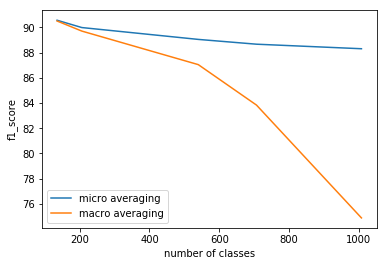

In [0]:
number_of_classes = [1008, 707, 540, 206, 135]
results_mic = [88.31, 88.67, 89.05, 89.99, 90.57]
results_mac = [74.89, 83.84, 87.05, 89.71, 90.51]
plt.plot(number_of_classes, results_mic)
plt.plot(number_of_classes, results_mac)
plt.legend(['micro averaging', 'macro averaging'])
plt.xlabel('number of classes')
plt.ylabel('f1_score')
#plt.title('BiLSTM validation results / f1')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


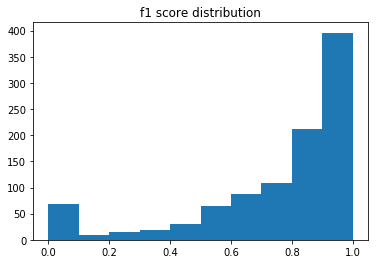

In [0]:
plt.hist(np.sort(f1_score(val_references, val_predictions, average=None)))
plt.title('f1 score distribution')
indices = np.argsort(f1_score(val_references, val_predictions, average=None))[:10]

In [0]:
from sklearn.metrics import confusion_matrix
np.argsort(confusion_matrix(val_references, val_predictions)[159, :])[::-1]
confusion_matrix(val_references, val_predictions)[159, :].nonzero()

(array([  6,   8,  24,  28,  38,  59, 104, 129, 159, 160, 185, 193, 200,
        201]),)